<a href="https://colab.research.google.com/github/frcomarinromero/MMF-VQA/blob/main/MMF_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduccion
---



Implementación de [MMF](https://github.com/facebookresearch/mmf) en Pytorch usando la base de datos [VQA](https://visualqa.org/) en conjunto con las librerías [Detectron2](https://github.com/facebookresearch/detectron2) y el modelo pre entrenado de [Pythia](https://arxiv.org/abs/1904.08920)

## Primero descargamos todos los datos necesarios
---

In [ ]:
# Descargamos los pre requisitos para poder correr el modelo E2E
%cd /content/

%mkdir model_data
!wget -O /content/model_data/answers_vqa.txt https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt
!wget -O /content/model_data/vocabulary_100k.txt https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
!wget -O /content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
!wget -O /content/model_data/pythia.pth https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.pth
!wget -O /content/model_data/pythia.yaml https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.yml
!wget -O /content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml
!wget -O /content/model_data/detectron_weights.tar.gz https://dl.fbaipublicfiles.com/pythia/data/detectron_weights.tar.gz
!tar xf /content/model_data/detectron_weights.tar.gz

/content
mkdir: cannot create directory ‘model_data’: File exists
--2021-08-04 17:06:02--  https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24768 (24K) [text/plain]
Saving to: ‘/content/model_data/answers_vqa.txt’

/content/model_data 100%[===================>]  24.19K  --.-KB/s    in 0.01s   

2021-08-04 17:06:02 (1.97 MB/s) - ‘/content/model_data/answers_vqa.txt’ saved [24768/24768]

--2021-08-04 17:06:02--  https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

## Instalamos las dependencias particulares
---



In [ ]:
!pip install yacs cython matplotlib
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI
!pip install pytorch-lightning

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-oi3xa0hb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-oi3xa0hb
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263900 sha256=70fafab4b72abed2d554ea6bb81f0ffdb8645b1b537ec27af7e701a8ef2c0b2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-och9xdd2/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmf 1.0.0rc12 requires pycocotools==2.0.2, but you have pycocotools 2.0 which is incompatible.


## Instalamos MMF
---
**Es importante mencionar que esto lo debemos de hacer desde el repositorio de git**, tambien podriamos hacerlo usando pipi, pero como esta librería está activamente en desarrollo es mejor usar la última versión


In [1]:
%cd /content/
%rm -rf mmf
!git clone https://github.com/facebookresearch/mmf.git mmf
%cd /content/mmf
# no debemos de modificar la version de torch, o si es necesario necesitamos
# revisar la compatibilidad de las demas librerias
!sed -i '/torch/d' requirements.txt
!pip install -e .
import sys
sys.path.append("/content/mmf")

/content
Cloning into 'mmf'...
remote: Enumerating objects: 20694, done.
remote: Counting objects: 100% (389/389), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 20694 (delta 288), reused 266 (delta 193), pack-reused 20305
Receiving objects: 100% (20694/20694), 15.77 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (13257/13257), done.
/content/mmf
Obtaining file:///content/mmf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... canceled
ERROR: Operation cancelled by user


## Instalamos maskrcnn-benchmark
---



In [ ]:
# Install maskrcnn-benchmark to extract detectron features
%cd /content
!git clone https://gitlab.com/meetshah1995/vqa-maskrcnn-benchmark.git
%cd /content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
sys.path.append('/content/vqa-maskrcnn-benchmark')

/content
fatal: destination path 'vqa-maskrcnn-benchmark' already exists and is not an empty directory.
/content/vqa-maskrcnn-benchmark
running build
running build_py
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:370: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running develop
running egg_info
writing maskrcnn_benchmark.egg-info/PKG-INFO
writing dependency_links to maskrcnn_benchmark.egg-info/dependency_links.txt
writing top-level names to maskrcnn_benchmark.egg-info/top_level.txt
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:370: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
adding license file 'LICENSE'
writing man

## Demo
---
Esta clase maneja la mayor parte de los requerimientos, extracción de características, la extracción de tokens y la predicción de la respuesta.

In [ ]:
%cd /content/
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO
from argparse import Namespace


from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


from mmf.datasets.processors.processors import VocabProcessor, VQAAnswerProcessor
from mmf.models.pythia import Pythia
from mmf.common.registry import registry
from mmf.common.sample import Sample, SampleList
from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration

setup_imports()

class MMFDemo:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    self._init_processors()
    self.pythia_model = self._build_pythia_model()
    self.detection_model = self._build_detection_model()
    self.resnet_model = self._build_resnet_model()
    
  def _init_processors(self):
    args = Namespace()
    args.opts = [
        "config=projects/pythia/configs/vqa2/defaults.yaml",
        "datasets=vqa2",
        "model=pythia",
        "evaluation.predict=True"
    ]
    args.config_override = None

    configuration = Configuration(args=args)
    
    config = self.config = configuration.config
    vqa_config = config.dataset_config.vqa2
    text_processor_config = vqa_config.processors.text_processor
    answer_processor_config = vqa_config.processors.answer_processor
    
    text_processor_config.params.vocab.vocab_file = "/content/model_data/vocabulary_100k.txt"
    answer_processor_config.params.vocab_file = "/content/model_data/answers_vqa.txt"
    # Add preprocessor as that will needed when we are getting questions from user
    self.text_processor = VocabProcessor(text_processor_config.params)
    self.answer_processor = VQAAnswerProcessor(answer_processor_config.params)

    registry.register("vqa2_text_processor", self.text_processor)
    registry.register("vqa2_answer_processor", self.answer_processor)
    registry.register("vqa2_num_final_outputs", 
                      self.answer_processor.get_vocab_size())
    
  def _build_pythia_model(self):
    state_dict = torch.load('/content/model_data/pythia.pth')
    model_config = self.config.model_config.pythia
    model_config.model_data_dir = "/content/"
    model = Pythia(model_config)
    model.build()
    model.init_losses()
    
    if list(state_dict.keys())[0].startswith('module') and \
       not hasattr(model, 'module'):
      state_dict = self._multi_gpu_state_to_single(state_dict)
          
    model.load_state_dict(state_dict, strict=False)
    model.to("cuda")
    model.eval()
    
    return model
  
  def _build_resnet_model(self):
    self.data_transforms = transforms.Compose([
        transforms.Resize(self.TARGET_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(self.CHANNEL_MEAN, self.CHANNEL_STD),
    ])
    resnet152 = models.resnet152(pretrained=True)
    resnet152.eval()
    modules = list(resnet152.children())[:-2]
    self.resnet152_model = torch.nn.Sequential(*modules)
    self.resnet152_model.to("cuda")
  
  def _multi_gpu_state_to_single(self, state_dict):
    new_sd = {}
    for k, v in state_dict.items():
        if not k.startswith('module.'):
            raise TypeError("Not a multiple GPU state of dict")
        k1 = k[7:]
        new_sd[k1] = v
    return new_sd
  
  def predict(self, url, question):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)
      resnet_features = self.get_resnet_features(url)

      sample = Sample()

      processed_text = self.text_processor({"text": question})
      sample.text = processed_text["text"]
      sample.text_len = len(processed_text["tokens"])

      sample.image_feature_0 = detectron_features
      sample.image_info_0 = Sample({
          "max_features": torch.tensor(100, dtype=torch.long)
      })

      sample.image_feature_1 = resnet_features

      sample_list = SampleList([sample])
      sample_list = sample_list.to("cuda")

      scores = self.pythia_model(sample_list)["scores"]
      scores = torch.nn.functional.softmax(scores, dim=1)
      actual, indices = scores.topk(5, dim=1)

      top_indices = indices[0]
      top_scores = actual[0]

      probs = []
      answers = []

      for idx, score in enumerate(top_scores):
        probs.append(score.item())
        answers.append(
            self.answer_processor.idx2word(top_indices[idx].item())
        )
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return probs, answers
    
  
  def _build_detection_model(self):

      cfg.merge_from_file('/content/model_data/detectron_model.yaml')
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load('/content/model_data/detectron_model.pth', 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
      return feat_list

  def masked_unk_softmax(self, x, dim, mask_idx):
      x1 = F.softmax(x, dim=dim)
      x1[:, mask_idx] = 0
      x1_sum = torch.sum(x1, dim=1, keepdim=True)
      y = x1 / x1_sum
      return y
   
  def get_resnet_features(self, image_path):
      path = self.get_actual_image(image_path)
      img = Image.open(path).convert("RGB")
      img_transform = self.data_transforms(img)
      
      if img_transform.shape[0] == 1:
        img_transform = img_transform.expand(3, -1, -1)
      img_transform = img_transform.unsqueeze(0).to("cuda")
      
      features = self.resnet152_model(img_transform).permute(0, 2, 3, 1)
      features = features.view(196, 2048)
      return features
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      return feat_list[0]
    

/content


### Creacion de modelo 
---
Una vez que tenemos definida nuestra clase demo comenzamos con el entrenamiento y la creación del modelo para ser usado en el próximo ejemplo
 
**Si el comando falla con la excepción 'CUDNN_EXECUTION_FAILED', intentamos a volver a ejecutarlo de nuevo**


In [ ]:
demo = MMFDemo()

/content/mmf/mmf/utils/configuration.py:491: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver("device_count", lambda: device_count)
/content/mmf/mmf/utils/configuration.py:492: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver("resolve_cache_dir", resolve_cache_dir)
/content/mmf/mmf/utils/configuration.py:493: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver("resolve_dir", resolve_dir)
/usr/local/lib/python3.7/dist-packages/omegaconf/grammar_visitor.py:257: UserWarning: In the sequence `MMF_USER_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
/usr/local/li

## Ejemplo de predicción 
---
La URL de la imagen puede ser cualquier URL http / https. Mostramos las 5 mejores predicciones de MMF. La confianza muestra el porcentaje de confianza que tenía el modelo MMF sobre la predicción en particular.

Text(value='http://images.cocodataset.org/train2017/000000305538.jpg', description='Image URL')

Text(value='where is this place?', description='Question')

Button(description='Ask MMF!', style=ButtonStyle())

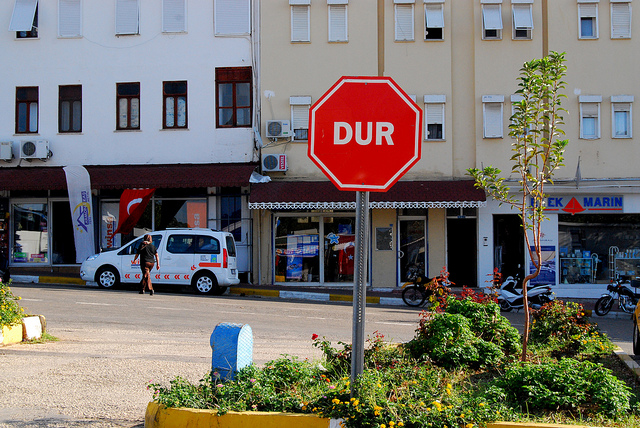

,Prediction,Confidence
0,town,19.188716
1,street,17.983322
2,road,12.409967
3,downtown,7.576017
4,outside,7.376473


In [ ]:
def init_widgets(url, question):
  image_text = widgets.Text(
    description="URL Imagen", layout=Layout(minwidth="70%")
  )
  question_text = widgets.Text(
      description="Pregunta", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  question_text.value = question
  submit_button = widgets.Button(description="Pregunta a MMF!")

  display(image_text)
  display(question_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text, question_text
  ))
  
  return image_text, question_text
  
def on_button_click(b, image_text, question_text):
  clear_output()
  image_path = demo.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  scores, predictions = demo.predict(image_text.value, question_text.value)
  scores = [score * 100 for score in scores]
  df = pd.DataFrame({
      "Prediction": predictions,
      "Confidence": scores
  })
  
  init_widgets(image_text.value, question_text.value)
  display(image)
  
  display(HTML(df.to_html()))
 

image_text, question_text = init_widgets(
    "http://images.cocodataset.org/train2017/000000505539.jpg", 
    "where is this place?"
)


##Referencia:
---
@misc{singh2020mmf,
  author =       {Singh, Amanpreet and Goswami, Vedanuj and Natarajan, Vivek and Jiang, Yu and Chen, Xinlei and Shah, Meet and
                 Rohrbach, Marcus and Batra, Dhruv and Parikh, Devi},
  title =        {MMF: A multimodal framework for vision and language research},
  howpublished = {\url{https://github.com/facebookresearch/mmf}},
  year =         {2020}
}
